**Acurácias** </br>
CNN: 95.22 % </br>
Densa: 90,67%



#Importanto o Kuzushiji-MNIST:

In [1]:
import requests

try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, total, unit: x  # If tqdm doesn't exist, replace it with a function that does nothing
    print('**** Could not import tqdm. Please install tqdm for download progressbars! (pip install tqdm) ****')

# Python2 compatibility
try:
    input = raw_input
except NameError:
    pass

download_dict = {
    '1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)': {
        '1) MNIST data format (ubyte.gz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-labels-idx1-ubyte.gz'],
        '2) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz'],
    },
    '2) Kuzushiji-49 (49 classes, 28x28, 270k examples)': {
        '1) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz'],
    },
    '3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)': {
        '1) Folders of images (.tar)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar'],
    }

}

# Download a list of files
def download_list(url_list):
    for url in url_list:
        path = url.split('/')[-1]
        r = requests.get(url, stream=True)
        with open(path, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            print('Downloading {} - {:.1f} MB'.format(path, (total_length / 1024000)))

            for chunk in tqdm(r.iter_content(chunk_size=1024), total=int(total_length / 1024) + 1, unit="KB"):
                if chunk:
                    f.write(chunk)
    print('All dataset files downloaded!')

# Ask the user about which path to take down the dict
def traverse_dict(d):
    print('Please select a download option:')
    keys = sorted(d.keys())  # Print download options
    for key in keys:
        print(key)

    userinput = input('> ').strip()

    try:
        selection = int(userinput) - 1
    except ValueError:
        print('Your selection was not valid')
        traverse_dict(d)  # Try again if input was not valid
        return

    selected = keys[selection]

    next_level = d[selected]
    if isinstance(next_level, list):  # If we've hit a list of downloads, download that list
        download_list(next_level)
    else:
        traverse_dict(next_level)     # Otherwise, repeat with the next level

traverse_dict(download_dict)

Please select a download option:
1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)
2) Kuzushiji-49 (49 classes, 28x28, 270k examples)
3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)
> 1
Please select a download option:
1) MNIST data format (ubyte.gz)
2) NumPy data format (.npz)
> 2


100%|██████████| 17954/17954 [00:09<00:00, 1889.76KB/s]


100%|██████████| 30/30 [00:00<00:00, 398.23KB/s]


100%|██████████| 3008/3008 [00:01<00:00, 1608.89KB/s]


100%|██████████| 6/6 [00:00<00:00, 21675.99KB/s]

All dataset files downloaded!


# Realizando o load e visualizando as imagens


In [2]:
import numpy as np

In [15]:
AX = np.load("kmnist-train-imgs.npz")['arr_0']
AY = np.load("kmnist-train-labels.npz")['arr_0']
QX = np.load("kmnist-test-imgs.npz")['arr_0']
QY = np.load("kmnist-test-labels.npz")['arr_0']

20 imagens:

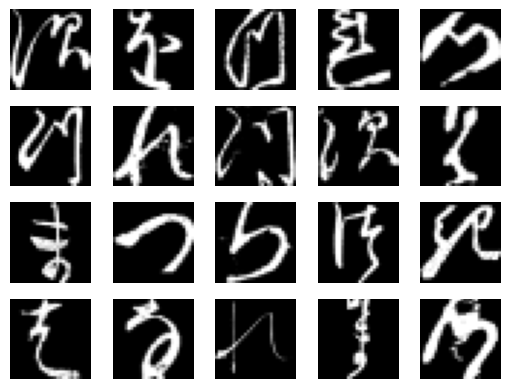

In [4]:
from matplotlib import pyplot as plt
f = plt.figure()
for i in range(20):
  f.add_subplot(4,5,i+1)
  plt.imshow( QX[i,:,:], cmap="gray") #tirei os limites vmax = +0.5 e vmin = -0.5
  plt.axis("off");
plt.savefig("nomefigura.png")
plt.show()

# Rede convolucional:

In [10]:
#cnn1.py - pos2021
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import optimizers
import numpy as np; import sys; import os; from time import time

AX=255-AX; QX=255-QX
nclasses = 10

nl, nc = AX.shape[1], AX.shape[2] #28, 28
AX = (AX.astype('float32') / 255.0)-0.5 # -0.5 a +0.5
QX = (QX.astype('float32') / 255.0)-0.5 # -0.5 a +0.5
AX = np.expand_dims(AX,axis=3) # AX [60000,28,28,1]
QX = np.expand_dims(QX,axis=3)


model = Sequential() # 28x28
model.add(Conv2D(20, kernel_size=(5,5), activation='relu',
 input_shape=(nl, nc, 1) )) #20x24x24
model.add(MaxPooling2D(pool_size=(2,2))) #20x12x12
model.add(Conv2D(40, kernel_size=(5,5), activation='relu')) #40x8x8
model.add(MaxPooling2D(pool_size=(2,2))) #40x4x4
model.add(Flatten()) #640
model.add(Dense(200, activation='relu')) #200
model.add(Dense(nclasses, activation='softmax')) #10


from tensorflow.keras.utils import plot_model
plot_model(model, to_file='cnn1.png', show_shapes=True);
model.summary()
opt=optimizers.Adam()
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
t0=time()
model.fit(AX, AY, batch_size=100, epochs=30, verbose=2)
t1=time(); print("Tempo de treino: %.2f s"%(t1-t0))
score = model.evaluate(QX, QY, verbose=False)
print('Test loss: %.4f'%(score[0]))
print('Test accuracy: %.2f %%'%(100*score[1]))
print('Test error: %.2f %%'%(100*(1-score[1])))
t2=time()
QP2=model.predict(QX); QP=np.argmax(QP2,1)
t3=time(); print("Tempo de predicao: %.2f s"%(t3-t2))
nerro=np.count_nonzero(QP-QY); print("nerro=%d"%(nerro))
model.save('cnn1.h5')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 20)        520       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 20)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 40)          20040     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 40)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 640)               0         
                                                                 
 dense_8 (Dense)             (None, 200)              

# Rede densa:

In [16]:
# mlp1.py
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Normalization
from tensorflow.keras import optimizers
import numpy as np; import sys


AX=255-AX; QX=255-QX
nclasses = 10

nl, nc = AX.shape[1], AX.shape[2] #28, 28

#Pseudo-normalizacao
#AX = (AX.astype('float32')/255.0)-0.5 # -0.5 a +0.5
#QX = (QX.astype('float32')/255.0)-0.5 # -0.5 a +0.5
#Normalizacao1 - distribuicao normal de media zero e desvio 1
#media=np.mean(AX); desvio=np.std(AX)
#AX=AX.astype('float32'); AX=AX-media; AX=AX/desvio; QX=QX.astype('float32'); QX=QX-media; QX=QX/desvio
#Normalizacao2 - inserir camada de normalizacao na rede

model = Sequential()
model.add(Normalization(input_shape=(nl,nc))) #Normaliza
model.add(Flatten())
model.add(Dense(400, activation='sigmoid'))
model.add(Dense(nclasses, activation='sigmoid'))

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='mlp1.png', show_shapes=True)
model.summary()
opt=optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.get_layer(index=0).adapt(AX) #Calcula media e desvio
model.fit(AX, AY, batch_size=100, epochs=40, verbose=2)
score = model.evaluate(QX, QY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
model.save('mlp1.h5')


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, 28, 28)           57        
 ion)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_16 (Dense)            (None, 400)               314000    
                                                                 
 dense_17 (Dense)            (None, 10)                4010      
                                                                 
Total params: 318,067
Trainable params: 318,010
Non-trainable params: 57
_________________________________________________________________
Epoch 1/40
600/600 - 3s - loss: 0.6215 - accuracy: 0.8171 - 3s/epoch - 4ms/step
Epoch 2/40
600/600 - 1s - loss: 0